# CascadeLSTM

In [1]:
import os, sys

sys.path.append('../code/')

import numpy as np
import torch as th
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import argparse
from datetime import datetime
from utils import *
from model import DeepTreeLSTMClassifier, DeepTreeLSTMRegressor
from dataset import CascadeData
from trainer import DeepTreeTrainer
from callbacks import EarlyStopping, ExperimentLogger
from itertools import product

Using backend: pytorch


## CascadeLSTM Regression

This section is about Regression on cascade-like datasets.

In [2]:
# experiment settings
x_size = 12
emo_size = 8
h_size = 8
top_size = (16, 16)

# train settings
epochs = 60
batch_size = 8
lr_tree = 0.05
lr_top = 0.01
decay_tree = 0.003
decay_top = 0.006
p_drop = 0.1

device = th.device('cpu')

data_dir = '../data/'
graphs_dir = data_dir + 'graphs/'
out_dir = '../results/'
cascade_size_file = data_dir + 'cascade_size.csv'

variant = '1_hour'


In [4]:
# ---------------------------------------------
# Parameter Tuning
# ---------------------------------------------


train_ids = np.array([ID.split('_')[0] for ID in os.listdir(graphs_dir) if variant in ID and 'test' not in ID])
test_ids = np.unique([ID.split('_')[0] for ID in os.listdir(graphs_dir) if variant + '_test' in ID])

train_set = CascadeData(train_ids, data_dir, variant=variant)
test_set = CascadeData(test_ids, data_dir, test=True, variant=variant)

h_sizes = [3,8,10]
batch_sizes = [8,16]
dropouts = [0.1, 0.15]
lr_trees = [0.01, 0.05]
lr_tops = [0.01, 0.05]

for h_size, dropout, batch_size, lr_tree, lr_top in product(h_sizes, dropouts, batch_sizes, lr_trees, lr_tops):
    print(f'Start experiment with h_size: {h_size}, top_size: {top_size}, batch_size: {batch_size}')
    train_generator = DataLoader(train_set, collate_fn=cascade_batcher(device), batch_size= batch_size, num_workers=8)
    test_generator = DataLoader(test_set, collate_fn=cascade_batcher(device), batch_size= batch_size, num_workers=8)

    deep_tree = DeepTreeLSTMRegressor(x_size, emo_size, h_size=h_size, top_sizes=top_size, pd=dropout)

    criterion = nn.MSELoss().to(device)
    optimizer_tree = optim.SGD(deep_tree.bottom_net.parameters(), lr = lr_tree, weight_decay = decay_tree)
    optimizer_top = optim.SGD(deep_tree.top_net.parameters(), lr = lr_top, weight_decay = decay_top)
    scheduler_tree = optim.lr_scheduler.StepLR(optimizer_tree, step_size=10, gamma=0.8)
    scheduler_top = optim.lr_scheduler.StepLR(optimizer_top, step_size=10, gamma=0.8)

    callbacks = [EarlyStopping(patience=10),
                ExperimentLogger(out_dir, filename='parameter_tuning_4.csv')]

    model_trainer = DeepTreeTrainer(deep_tree)
    model_trainer.compile(optimizer_tree, optimizer_top, criterion, scheduler_tree=scheduler_tree, scheduler_top=scheduler_top, callbacks=callbacks, metrics=['mae'])
    model_trainer.fit(train_generator, test_generator, epochs, verbose=0)
    val_loss = min(model_trainer.history['val_loss'])

    print(f'Experiment ended with val_loss: {val_loss:.6f}')

Start experiment with h_size: 3, top_size: (16, 16), batch_size: 8
Experiment ended with val_loss: 0.485300
Start experiment with h_size: 3, top_size: (16, 16), batch_size: 8
Experiment ended with val_loss: 0.585899
Start experiment with h_size: 3, top_size: (16, 16), batch_size: 8
Experiment ended with val_loss: 0.486926
Start experiment with h_size: 3, top_size: (16, 16), batch_size: 8
Experiment ended with val_loss: 0.503936
Start experiment with h_size: 3, top_size: (16, 16), batch_size: 16
Experiment ended with val_loss: 0.518387
Start experiment with h_size: 3, top_size: (16, 16), batch_size: 16
Experiment ended with val_loss: 0.496302
Start experiment with h_size: 3, top_size: (16, 16), batch_size: 16
Experiment ended with val_loss: 0.481936
Start experiment with h_size: 3, top_size: (16, 16), batch_size: 16
Experiment ended with val_loss: 0.522263
Start experiment with h_size: 3, top_size: (16, 16), batch_size: 8
Experiment ended with val_loss: 0.500883
Start experiment with h_

In [4]:
# ---------------------------------------------
# Experiment 1
# ---------------------------------------------

variants = ['15_mins', '30_mins', '1_hour', '3_hour', '24_hour']

for variant in variants:
    train_ids = np.array([ID.split('_')[0] for ID in os.listdir(graphs_dir) if variant in ID and 'test' not in ID])
    test_ids = np.unique([ID.split('_')[0] for ID in os.listdir(graphs_dir) if variant + '_test' in ID])

    train_set = CascadeData(train_ids, graphs_dir, cascade_size_file, variant=variant)
    test_set = CascadeData(test_ids, graphs_dir, cascade_size_file, test=True, variant=variant)


    for i in range(6):
        print(f'Start experiment {variant} run {i+1}/6:')
        train_generator = DataLoader(train_set, collate_fn=cascade_batcher(device), batch_size= batch_size, num_workers=8)
        test_generator = DataLoader(test_set, collate_fn=cascade_batcher(device), batch_size= batch_size, num_workers=8)

        deep_tree = DeepTreeLSTMRegressor(x_size, emo_size, h_size=h_size, top_sizes=top_size, pd=p_drop)

        criterion = nn.MSELoss().to(device)
        optimizer_tree = optim.SGD(deep_tree.bottom_net.parameters(), lr = lr_tree, weight_decay = decay_tree)
        optimizer_top = optim.SGD(deep_tree.top_net.parameters(), lr = lr_top, weight_decay = decay_top)
        scheduler_tree = optim.lr_scheduler.StepLR(optimizer_tree, step_size=10, gamma=0.8)
        scheduler_top = optim.lr_scheduler.StepLR(optimizer_top, step_size=10, gamma=0.8)

        callbacks = [EarlyStopping(patience=10),
                    ExperimentLogger(out_dir, filename='experiment_2.csv')]

        model_trainer = DeepTreeTrainer(deep_tree)
        model_trainer.compile(optimizer_tree, optimizer_top, criterion, scheduler_tree=scheduler_tree, scheduler_top=scheduler_top, callbacks=callbacks, metrics=['mae'])
        model_trainer.fit(train_generator, test_generator, epochs, verbose=0)
        val_loss = min(model_trainer.history['val_loss'])

        print(f'Experiment ended with val_loss: {val_loss:.6f}')

Start experiment 15_mins run 1/6:
Experiment ended with val_loss: 0.594222
Start experiment 15_mins run 2/6:
Experiment ended with val_loss: 0.589094
Start experiment 15_mins run 3/6:
Experiment ended with val_loss: 0.595754
Start experiment 15_mins run 4/6:
Experiment ended with val_loss: 0.618543
Start experiment 15_mins run 5/6:
Experiment ended with val_loss: 0.599083
Start experiment 15_mins run 6/6:
Experiment ended with val_loss: 0.627943
Start experiment 30_mins run 1/6:
Experiment ended with val_loss: 0.600921
Start experiment 30_mins run 2/6:
Experiment ended with val_loss: 0.544450
Start experiment 30_mins run 3/6:
Experiment ended with val_loss: 0.504231
Start experiment 30_mins run 4/6:
Experiment ended with val_loss: 0.592791
Start experiment 30_mins run 5/6:
Experiment ended with val_loss: 0.546265
Start experiment 30_mins run 6/6:
Experiment ended with val_loss: 0.525734
Start experiment 1_hour run 1/6:
Experiment ended with val_loss: 0.487719
Start experiment 1_hour ru

In [3]:
# ---------------------------------------------
# Experiment 1: Model Variations
# ---------------------------------------------

variant = '1_hour'
variation_graphs_dir = data_dir + 'graphs_variations/'


variations = { #(structureless, bi, deep)
    'structureless' : (True, True, True),
    'regular' : (False, True, True),
    'unidirectional' : (False, False, True),
    'no_emotions' : (False, True, False),
    'regular_tree' : (False, False, False)
}

for variation, (structureless, bi, deep) in variations.items():
    train_ids = np.unique([ID.split('_')[0] for ID in os.listdir(variation_graphs_dir) if variant in ID and 'test' not in ID])
    test_ids = np.unique([ID.split('_')[0] for ID in os.listdir(variation_graphs_dir) if variant + '_test' in ID])

    train_set = CascadeData(train_ids, variation_graphs_dir, cascade_size_file, variant=variant, structureless=structureless)
    test_set = CascadeData(test_ids, variation_graphs_dir, cascade_size_file, test=True, variant=variant, structureless=structureless)

    x_size_variations = x_size
    if structureless:
        x_size_variations = x_size - 2

    for i in range(6):
        print(f'Start experiment {variation} run {i+1}/6:')
        train_generator = DataLoader(train_set, collate_fn=cascade_batcher(device), batch_size= batch_size, num_workers=8)
        test_generator = DataLoader(test_set, collate_fn=cascade_batcher(device), batch_size= batch_size, num_workers=8)


        deep_tree = DeepTreeLSTMRegressor(x_size_variations, emo_size, h_size=h_size, top_sizes=top_size, pd=p_drop, bi=bi, deep=deep)

        criterion = nn.MSELoss().to(device)
        optimizer_tree = optim.SGD(deep_tree.bottom_net.parameters(), lr = lr_tree, weight_decay = decay_tree)
        optimizer_top = optim.SGD(deep_tree.top_net.parameters(), lr = lr_top, weight_decay = decay_top)
        scheduler_tree = optim.lr_scheduler.StepLR(optimizer_tree, step_size=10, gamma=0.8)
        scheduler_top = optim.lr_scheduler.StepLR(optimizer_top, step_size=10, gamma=0.8)

        callbacks = [EarlyStopping(patience=10),
                    ExperimentLogger(out_dir, filename='experiment_2_variations.csv')]

        model_trainer = DeepTreeTrainer(deep_tree)
        model_trainer.compile(optimizer_tree, optimizer_top, criterion, scheduler_tree=scheduler_tree, scheduler_top=scheduler_top, callbacks=callbacks, metrics=['mae'])
        model_trainer.fit(train_generator, test_generator, epochs, verbose=0)
        val_loss = min(model_trainer.history['val_loss'])

        print(f'Experiment ended with val_loss: {val_loss:.6f}')

Start experiment structureless run 1/6:
Experiment ended with val_loss: 0.447984
Start experiment structureless run 2/6:
Experiment ended with val_loss: 0.443082
Start experiment structureless run 3/6:
Experiment ended with val_loss: 0.488214
Start experiment structureless run 4/6:
Experiment ended with val_loss: 0.478036
Start experiment structureless run 5/6:
Experiment ended with val_loss: 0.475786
Start experiment structureless run 6/6:
Experiment ended with val_loss: 0.439464
Start experiment regular run 1/6:
Experiment ended with val_loss: 0.439656
Start experiment regular run 2/6:
Experiment ended with val_loss: 0.441569
Start experiment regular run 3/6:
Experiment ended with val_loss: 0.461005
Start experiment regular run 4/6:
Experiment ended with val_loss: 0.425366
Start experiment regular run 5/6:
Experiment ended with val_loss: 0.455729
Start experiment regular run 6/6:
Experiment ended with val_loss: 0.445083
Start experiment unidirectional run 1/6:
Experiment ended with v

In [5]:
# ---------------------------------------------
# Single run
# ---------------------------------------------

train_ids = np.array([ID.split('_')[0] for ID in os.listdir(graphs_dir) if variant in ID and 'test' not in ID])
test_ids = np.unique([ID.split('_')[0] for ID in os.listdir(graphs_dir) if variant + '_test' in ID])

train_set = CascadeData(train_ids, graphs_dir, cascade_size_file, variant=variant)
test_set = CascadeData(test_ids, graphs_dir, cascade_size_file, test=True, variant=variant)

train_generator = DataLoader(train_set, collate_fn=cascade_batcher(device), batch_size= batch_size, num_workers=8)
test_generator = DataLoader(test_set, collate_fn=cascade_batcher(device), batch_size= batch_size, num_workers=8)

deep_tree = DeepTreeLSTMRegressor(x_size, emo_size, h_size=h_size, top_sizes=top_size, pd=p_drop)

criterion = nn.MSELoss().to(device)
optimizer_tree = optim.SGD(deep_tree.bottom_net.parameters(), lr = lr_tree, weight_decay = decay_tree)
optimizer_top = optim.SGD(deep_tree.top_net.parameters(), lr = lr_top, weight_decay = decay_top)
scheduler_tree = optim.lr_scheduler.StepLR(optimizer_tree, step_size=10, gamma=0.8)
scheduler_top = optim.lr_scheduler.StepLR(optimizer_top, step_size=10, gamma=0.8)

callbacks = [ExperimentLogger(out_dir)]

model_trainer = DeepTreeTrainer(deep_tree)
model_trainer.compile(optimizer_tree, optimizer_top, criterion, scheduler_tree=scheduler_tree, scheduler_top=scheduler_top, callbacks=callbacks, metrics=['mae'])
model_trainer.fit(train_generator, test_generator, 60)

Epoch: 1/60
234/234 [########################################] - 23s 99ms/step - loss: 3.2964 - val_loss: 2.4612 - val_mae: 1.0326 
Epoch: 2/60
234/234 [########################################] - 27s 117ms/step - loss: 1.5789 - val_loss: 1.2101 - val_mae: 0.7673 
Epoch: 3/60
234/234 [########################################] - 27s 118ms/step - loss: 1.2186 - val_loss: 1.3457 - val_mae: 0.7886 
Epoch: 4/60
234/234 [########################################] - 28s 121ms/step - loss: 1.0744 - val_loss: 1.1446 - val_mae: 0.7396 
Epoch: 5/60
234/234 [########################################] - 27s 119ms/step - loss: 1.0203 - val_loss: 0.6568 - val_mae: 0.5837 
Epoch: 6/60
234/234 [########################################] - 27s 119ms/step - loss: 0.8297 - val_loss: 0.7062 - val_mae: 0.5914 
Epoch: 7/60
234/234 [########################################] - 28s 120ms/step - loss: 0.7789 - val_loss: 0.6477 - val_mae: 0.5769 
Epoch: 8/60
234/234 [########################################] - 28s 1

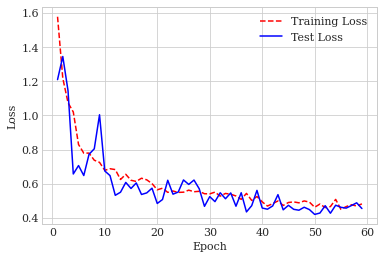

In [12]:
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

matplotlib.rcParams.update({'font.size':11,
                            'font.family':'serif'})
training_loss = model_trainer.history['loss'][1:]
test_loss = model_trainer.history['val_loss'][1:]

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
fig, ax = plt.subplots()
ax.plot(epoch_count, training_loss, 'r--')
ax.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
fig.savefig('../plots/loss_curve.pdf')